<h2>Import Libraries</h2><br>
This cell imports all the necessary libraries for data processing, model building, training, and evaluation. It also sets the device to GPU if available.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
from tqdm import tqdm

# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


<h2>Data Preprocessing</h2><br>
The section creates a data preprocessing pipeline and loads the training and validation datasets.<br>
Training data is shuffled for better generalization, while validation data is not shuffled to ensure consistent performance evaluation.

In [2]:
# Define the transformations and load the datasets
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Set the paths for the training and validation datasets
train_dataset = datasets.ImageFolder(root=r'C:\Users\dcken\Documents\DPA\brain_tumor\Training', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

val_dataset = datasets.ImageFolder(root=r'C:\Users\dcken\Documents\DPA\brain_tumor\Testing', transform=transform)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)


<h2>Data Visualization</h2><br>
The code focuses on visually inspecting images in each class of the training dataset.<br>
The visualize function displays a few randomly selected images from each class.<br>
This allows for quick quality checks of the images.<br>
It ensures that the dataset is correctly loaded and labeled.<br>
This process is particularly useful during the data preprocessing phase.<br>
It ensures that the images are correctly structured before training the model.<br>

GLIOMA


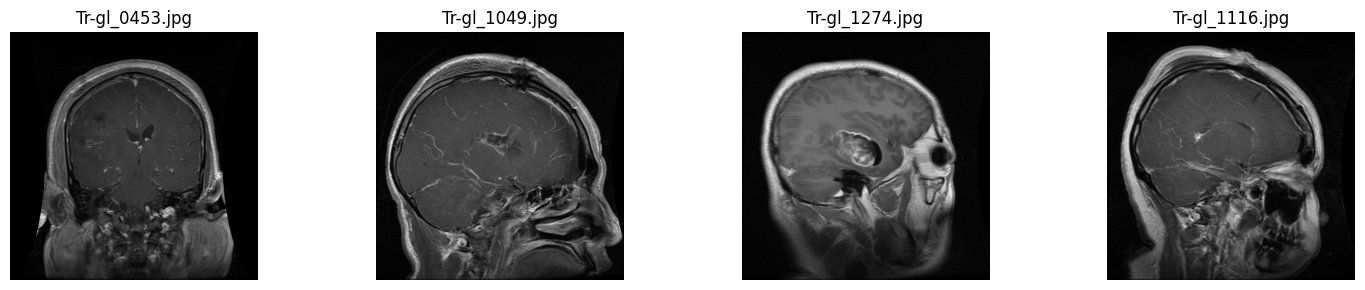

MENINGIOMA


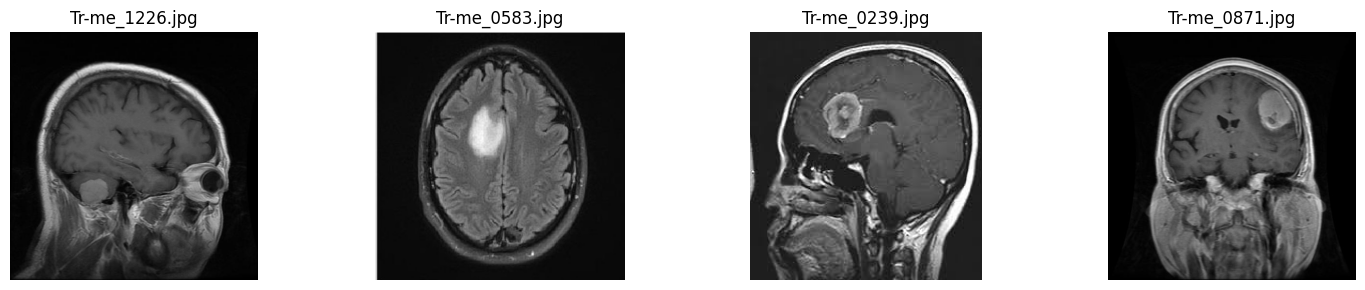

NOTUMOR


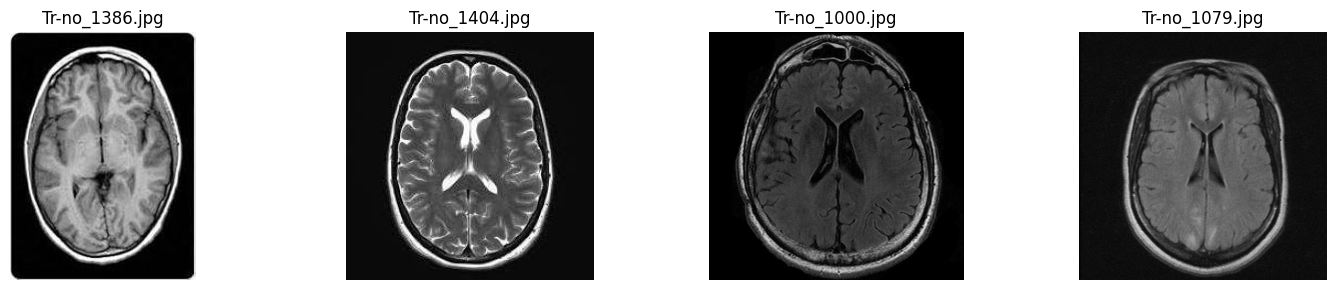

PITUITARY


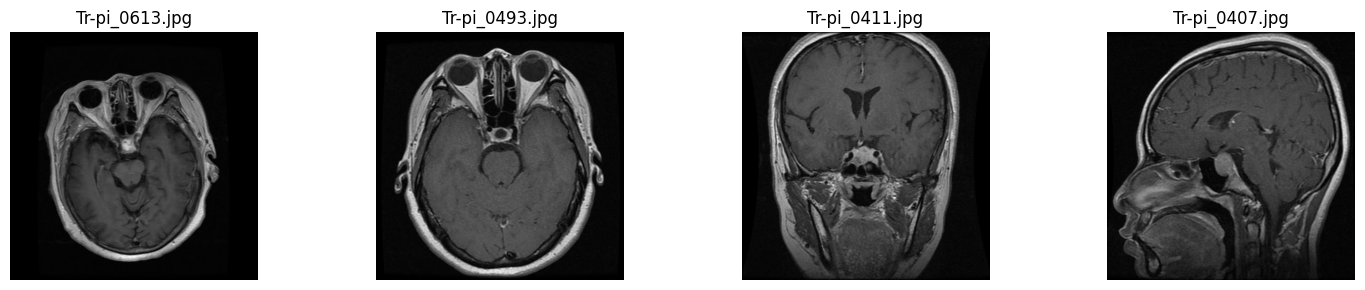

In [3]:
def visualize(path, num_images=5):
    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        print("No images found in the specified path")
        return

    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    for i, image_filename in enumerate(selected_images):
        image_path = os.path.join(path, image_filename)
        image = Image.open(image_path)

        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(image_filename)

    plt.tight_layout()
    plt.show()

classes = train_dataset.classes

for label in classes:
    path_to_viz = fr"C:\Users\dcken\Documents\DPA\brain_tumor\Training\{label}"
    print(label.upper())
    visualize(path_to_viz, num_images=4)


<h2>Load Pre-trained ResNet-50 Model</h2><br>
<b>Load the Pre-trained Model:</b>
Loads the ResNet-50 model with pre-trained weights for transfer learning.<br>
<b>Modify the Fully Connected Layer:</b>
Retrieves the number of input features for the fully connected layer.<br>
Replaces the fully connected layer to match the number of classes in the current dataset.<br>
<b>Move the Model to Device:</b>
Transfers the model to the GPU or CPU, depending on availability.

In [4]:
# Load the pre-trained ResNet-50 model
model = models.resnet50(weights='DEFAULT')

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))
model = model.to(device)

<h2>Define Loss Function and Optimizer</h2><br>
<b>Initialize the Loss Function:</b>
Uses Cross-Entropy Loss for multi-class classification.<br>
<b>Initialize the Optimizer:</b>
Uses the Adam optimizer to update the model's parameters.<br>
Sets the learning rate to 0.001 for controlling the update step size.

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

<h2>Training Loop</h2><br>
<b>Training Parameters and Initialization:</b>
Sets num_epochs to 20.<br>
Initializes lists to track training and validation loss and accuracy.<br>
<b>Training Loop:</b>
Iterates over epochs, setting the model to training mode.<br>
Accumulates and averages training loss and accuracy for each epoch.<br>
Displays real-time progress with a progress bar.<br>
<b>Validation Loop:</b>
Sets the model to evaluation mode.<br>
Accumulates and averages validation loss and accuracy without computing gradients.<br>
Displays epoch-wise training and validation metrics.<br>
<b>Final Output:</b>
Prints the metrics (loss and accuracy) for both training and validation at the end of each epoch.

In [6]:
# Training parameters
num_epochs = 20

# To track the training and validation loss and accuracy
training_loss = []
valid_loss = []
training_acc = []
valid_acc = []

# Training loop with progress bar and real-time updates
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_acc = 0

    # Training loop with progress bar
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False):
        images, labels = images.to(device), labels.to(device)  # Move images and labels to GPU

        optimizer.zero_grad()
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == labels.data)

    train_loss /= len(train_loader)
    train_acc = train_acc.double() / len(train_loader.dataset)

    training_loss.append(train_loss)
    training_acc.append(train_acc)

    # Validation loop
    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move validation data to GPU

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_acc += torch.sum(preds == labels.data)

    val_loss /= len(val_loader)
    val_acc = val_acc.double() / len(val_loader.dataset)

    valid_loss.append(val_loss)
    valid_acc.append(val_acc)

    # Display the current progress of the training
    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Epoch 1/20, Training Loss: 0.2800, Training Accuracy: 0.8969, Validation Loss: 0.3578, Validation Accuracy: 0.8578


Epoch 2/20, Training Loss: 0.1030, Training Accuracy: 0.9674, Validation Loss: 0.0722, Validation Accuracy: 0.9755


Epoch 3/20, Training Loss: 0.0695, Training Accuracy: 0.9792, Validation Loss: 0.1884, Validation Accuracy: 0.9419


Epoch 4/20, Training Loss: 0.0760, Training Accuracy: 0.9737, Validation Loss: 0.2663, Validation Accuracy: 0.8914


Epoch 5/20, Training Loss: 0.0338, Training Accuracy: 0.9883, Validation Loss: 0.0743, Validation Accuracy: 0.9771


Epoch 6/20, Training Loss: 0.0301, Training Accuracy: 0.9897, Validation Loss: 0.0654, Validation Accuracy: 0.9817


Epoch 7/20, Training Loss: 0.0388, Training Accuracy: 0.9869, Validation Loss: 0.3581, Validation Accuracy: 0.8823


Epoch 8/20, Training Loss: 0.0293, Training Accuracy: 0.9907, Validation Loss: 0.1134, Validation Accuracy: 0.9648


Epoch 9/20, Training Loss: 0.0439, Training Accuracy: 0.9855, Validation Loss: 0.4947, Validation Accuracy: 0.8524


Epoch 10/20, Training Loss: 0.0124, Training Accuracy: 0.9956, Validation Loss: 0.1892, Validation Accuracy: 0.9580


Epoch 11/20, Training Loss: 0.0106, Training Accuracy: 0.9967, Validation Loss: 0.2549, Validation Accuracy: 0.9251


Epoch 12/20, Training Loss: 0.0135, Training Accuracy: 0.9960, Validation Loss: 0.1297, Validation Accuracy: 0.9610


Epoch 13/20, Training Loss: 0.0512, Training Accuracy: 0.9827, Validation Loss: 0.2513, Validation Accuracy: 0.9235


Epoch 14/20, Training Loss: 0.0451, Training Accuracy: 0.9856, Validation Loss: 0.0700, Validation Accuracy: 0.9778


Epoch 15/20, Training Loss: 0.0106, Training Accuracy: 0.9968, Validation Loss: 0.0859, Validation Accuracy: 0.9732


Epoch 16/20, Training Loss: 0.0189, Training Accuracy: 0.9947, Validation Loss: 0.1645, Validation Accuracy: 0.9488


Epoch 17/20, Training Loss: 0.0199, Training Accuracy: 0.9949, Validation Loss: 1.2953, Validation Accuracy: 0.7905


Epoch 18/20, Training Loss: 0.0322, Training Accuracy: 0.9897, Validation Loss: 0.0775, Validation Accuracy: 0.9786


Epoch 19/20, Training Loss: 0.0140, Training Accuracy: 0.9960, Validation Loss: 0.0398, Validation Accuracy: 0.9862


Epoch 20/20, Training Loss: 0.0013, Training Accuracy: 0.9996, Validation Loss: 0.0369, Validation Accuracy: 0.9901


<h2>Plot Training and Validation Metrics</h2><br>
<b>Figure Setup:</b>
Creates a 12x5 inch figure to hold two subplots.<br>
<b>Data Conversion:</b>
Converts GPU tensors for training and validation accuracy to CPU-compatible NumPy arrays.<br>
Assigns loss values directly to variables for plotting.<br>
<b>Plotting Accuracy:</b>
Creates a subplot for accuracy.<br>
Plots training accuracy in red and validation accuracy in blue.<br>
Adds titles, axis labels, and a legend.<br>
<b>Plotting Loss:</b>
Creates a subplot for loss.<br>
Plots training loss in red and validation loss in blue.<br>
Adds titles, axis labels, and a legend.<br>
<b>Layout and Display:</b>
Adjusts subplot layout to prevent overlap.<br>
Displays the figure with the accuracy and loss plots side by side.

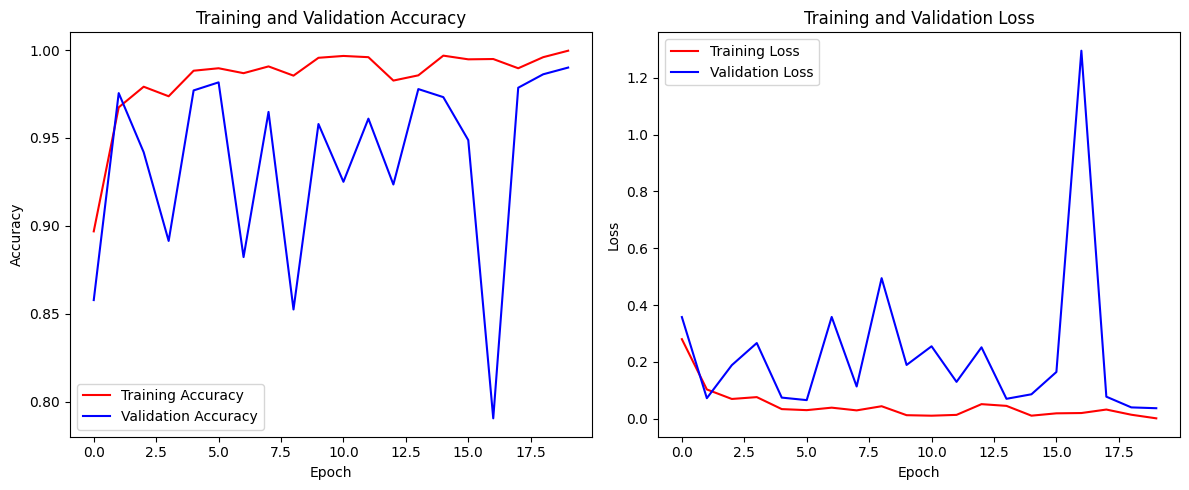

In [7]:
plt.figure(figsize=(12, 5))

training_acc_cpu = [acc.cpu().numpy() for acc in training_acc]
valid_acc_cpu = [acc.cpu().numpy() for acc in valid_acc]

training_loss_cpu = training_loss
valid_loss_cpu = valid_loss

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(training_acc_cpu, color='red', label='Training Accuracy')
plt.plot(valid_acc_cpu, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(training_loss_cpu, color='red', label='Training Loss')
plt.plot(valid_loss_cpu, color='blue', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

<h2>Evaluate Model with Confusion Matrix</h2><br>
<b>Model Evaluation:</b>
Sets the model to evaluation mode with model.eval().<br>
<b>Initialization:</b>
Initializes lists to store predictions and true labels.<br>
<b>Validation Loop:</b>
Disables gradient computation for efficiency.<br>
Iterates through validation data, moving it to the appropriate device.<br>
Predicts classes and stores both predictions and true labels.<br>
<b>Data Conversion:</b>
Converts lists of predictions and labels to NumPy arrays.<br>
<b>Confusion Matrix:</b>
Computes the confusion matrix to evaluate model performance.<br>
Uses ConfusionMatrixDisplay to visualize the confusion matrix with appropriate class labels and a blue color map.<br>
<b>Display:</b>
Adds a title to the confusion matrix plot and displays it.

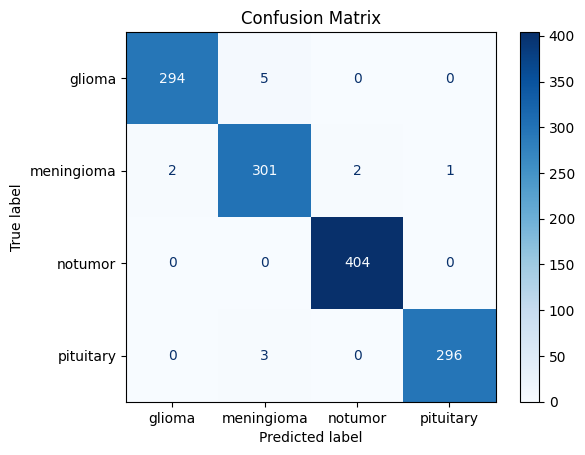

In [8]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


<h2>Save the Model</h2><br>
<b>Save Model State:</b>
Saves the model's state dictionary (learnable parameters) to a file named model.pth.<br>
Enables easy loading of the model for future use, such as inference or continued training.

In [9]:
torch.save(model.state_dict(), 'model.pth')